In [1]:
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import scipy.stats as stats

from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [2]:
mail_dataframe = pd.read_csv("mail_extract.csv", converters={'column_name': eval})

In [26]:
mail_dataframe.head()

,spam,from,subject,hour,content-type,importance,x-spam,x-*,html,url,mail,price,> count,? or !,Number count,Majuscule count,content_attr
0,1.0,"[17, 13, 'yahoo', 'com']","[4, 38, 1, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",3.0,text/html,NaN,NaN,4.0,16.0,0.0,0.0,1.0,0.0,5.0,4.0,47.0,"[81, 4.4815, 10, [0.0, 0.0, 0.0247, 0.0, 0.0, ..."
1,1.0,"[5, 0, 'mail', 'ru']","[5, 28, 1, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",15.0,NaN,NaN,NaN,3.0,0.0,0.0,1.0,27.0,0.0,23.0,88.0,1107.0,"[1290, 6.4512, 23, [0.0, 0.0, 0.013, 0.0008, 0..."
2,1.0,"[16, 0, 'netscape', 'net']","[2, 16, 0, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",8.0,text/plain,NaN,NaN,1.0,2.0,3.0,0.0,0.0,0.0,3.0,14.0,122.0,"[165, 6.5697, 121, [0.0, 0.0, 0.012, 0.0, 0.0,..."
3,1.0,"[9, 0, '2x12.2xthemoney', 'com']","[9, 41, 0, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",19.0,NaN,NaN,NaN,1.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,52.0,"[88, 5.375, 13, [0.0, 0.0, 0.0227, 0.0, 0.0, 0..."
4,1.0,"[10, 3, 'pac9.westernbarge', 'com']","[6, 37, 0, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",17.0,NaN,NaN,NaN,1.0,0.0,3.0,0.0,2.0,0.0,7.0,3.0,42.0,"[75, 5.0667, 12, [0.0, 0.0, 0.013, 0.0, 0.0, 0..."


In [27]:
mail_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9349 entries, 0 to 9348
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   spam             9349 non-null   float64
 1   from             9349 non-null   object 
 2   subject          9349 non-null   object 
 3   hour             9336 non-null   float64
 4   content-type     7696 non-null   object 
 5   importance       649 non-null    object 
 6   x-spam           35 non-null     object 
 7   x-*              9349 non-null   float64
 8   html             9349 non-null   float64
 9   url              9349 non-null   float64
 10  mail             9349 non-null   float64
 11  price            9349 non-null   float64
 12  > count          9349 non-null   float64
 13  ? or !           9349 non-null   float64
 14  Number count     9349 non-null   float64
 15  Majuscule count  9349 non-null   float64
 16  content_attr     9349 non-null   object 
dtypes: float64(11)

In [3]:
mail_dataframe = mail_dataframe.drop(["importance", "x-spam"], axis=1)

In [29]:
mail_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9349 entries, 0 to 9348
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   spam             9349 non-null   float64
 1   from             9349 non-null   object 
 2   subject          9349 non-null   object 
 3   hour             9336 non-null   float64
 4   content-type     7696 non-null   object 
 5   x-*              9349 non-null   float64
 6   html             9349 non-null   float64
 7   url              9349 non-null   float64
 8   mail             9349 non-null   float64
 9   price            9349 non-null   float64
 10  > count          9349 non-null   float64
 11  ? or !           9349 non-null   float64
 12  Number count     9349 non-null   float64
 13  Majuscule count  9349 non-null   float64
 14  content_attr     9349 non-null   object 
dtypes: float64(11), object(4)
memory usage: 1.1+ MB


In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(mail_dataframe, mail_dataframe["spam"]):
    strat_train_set = mail_dataframe.loc[train_index]
    strat_test_set = mail_dataframe.loc[test_index]

In [31]:
strat_test_set["spam"].value_counts()/len(strat_test_set)

0.0    0.743316
1.0    0.256684
Name: spam, dtype: float64

In [32]:
mail_dataframe.describe()

,spam,hour,x-*,html,url,mail,price,> count,? or !,Number count,Majuscule count
count,9349.000000,9336.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000,9349.000000
mean,0.256498,12.253320,3.689272,47.772703,2.664242,0.943951,0.828645,5.194352,3.278639,54.645524,220.538453
std,0.436723,5.995302,2.850173,162.505353,46.020764,1.883043,5.099916,30.623464,7.999820,610.299554,2501.362106
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,15.000000
50%,0.000000,12.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,8.000000,32.000000
75%,1.000000,17.000000,6.000000,2.000000,2.000000,1.000000,0.000000,4.000000,3.000000,16.000000,85.000000
max,1.000000,23.000000,20.000000,2299.000000,3131.000000,52.000000,237.000000,1683.000000,264.000000,23869.000000,115925.000000


In [5]:
train_set = strat_train_set.copy(deep=True)

In [34]:
train_set["from"] = strat_train_set["from"].apply(lambda x:literal_eval(x))
train_set["subject"] = strat_train_set["subject"].apply(lambda x:literal_eval(x))
train_set["content_attr"] = strat_train_set["content_attr"].apply(lambda x:literal_eval(x))

In [35]:
train_set["len_mail_name"] = train_set["from"].apply(lambda x:x[0])
train_set["number_mail_name"] = train_set["from"].apply(lambda x:x[1])
train_set["domain"] = train_set["from"].apply(lambda x:x[2])
train_set["extension"] = train_set["from"].apply(lambda x:x[3])
train_set = train_set.drop("from", axis=1)

In [36]:
train_set["subj_number_of_maj"] = train_set["subject"].apply(lambda x:x[0])
train_set["subj_number_of_char"] = train_set["subject"].apply(lambda x:x[1])
train_set["subj_number_of_special_char"] = train_set["subject"].apply(lambda x:x[2])
train_set["subj_number_of_price"] = train_set["subject"].apply(lambda x:x[3])
train_set["subj_number_of_number"] = train_set["subject"].apply(lambda x:x[4])
train_set["subj_common_word_list"] = train_set["subject"].apply(lambda x:x[5])
train_set = train_set.drop("subject", axis=1)

In [37]:
train_set["cont_number_of_word"] = train_set["content_attr"].apply(lambda x:x[0])
train_set["cont_mean_len_word"] = train_set["content_attr"].apply(lambda x:x[1])
train_set["cont_longuest_word"] = train_set["content_attr"].apply(lambda x:x[2])
train_set["cont_count_common_word"] = train_set["content_attr"].apply(lambda x:x[3])
train_set = train_set.drop("content_attr", axis=1)

In [38]:
train_set

,spam,hour,content-type,x-*,html,url,mail,price,> count,? or !,...,subj_number_of_maj,subj_number_of_char,subj_number_of_special_char,subj_number_of_price,subj_number_of_number,subj_common_word_list,cont_number_of_word,cont_mean_len_word,cont_longuest_word,cont_count_common_word
3101,0.0,23.0,text/plain; charset=US-ASCII,3.0,0.0,1.0,1.0,0.0,4.0,3.0,...,4,32,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",39,6.6667,47,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5148,0.0,13.0,text/plain,8.0,0.0,1.0,1.0,0.0,0.0,4.0,...,2,32,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,5.8780,14,"[0.0, 0.0244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3592,0.0,10.0,text/plain,7.0,0.0,2.0,3.0,1.0,21.0,2.0,...,5,59,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",296,5.3209,47,"[0.0, 0.0066, 0.0099, 0.0099, 0.0, 0.0033, 0.0..."
2250,1.0,15.0,NaN,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,9,35,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",114,5.6140,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1641,1.0,2.0,text/plain,3.0,0.0,0.0,1.0,3.0,0.0,1.0,...,9,44,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",144,5.2778,31,"[0.0, 0.0, 0.0066, 0.0, 0.0, 0.0, 0.0, 0.0066,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,1.0,8.0,text/html,0.0,200.0,0.0,0.0,2.0,0.0,14.0,...,37,66,1,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",183,5.4973,17,"[0.0, 0.0, 0.0104, 0.0, 0.0, 0.0052, 0.0, 0.00..."
7917,0.0,12.0,text/plain,6.0,1.0,1.0,1.0,0.0,1.0,1.0,...,4,45,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166...",151,4.9735,14,"[0.0, 0.0, 0.0197, 0.0132, 0.0, 0.0, 0.0, 0.00..."
5448,0.0,10.0,NaN,5.0,2.0,3.0,1.0,0.0,19.0,0.0,...,2,25,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",89,6.0787,47,"[0.0, 0.0, 0.011, 0.0, 0.0, 0.0, 0.0, 0.011, 0..."
4022,0.0,13.0,text/html,2.0,1088.0,0.0,2.0,0.0,0.0,19.0,...,6,32,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",636,5.3821,18,"[0.0, 0.0031, 0.0154, 0.0031, 0.0031, 0.0, 0.0..."


In [39]:
train_set.describe()

,spam,hour,x-*,html,url,mail,price,> count,? or !,Number count,...,len_mail_name,number_mail_name,subj_number_of_maj,subj_number_of_char,subj_number_of_special_char,subj_number_of_price,subj_number_of_number,cont_number_of_word,cont_mean_len_word,cont_longuest_word
count,7479.000000,7471.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,...,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000,7479.000000
mean,0.256451,12.244010,3.676026,49.164862,2.853590,0.965905,0.873780,4.755315,3.316219,60.811071,...,20.507153,0.842492,5.119802,38.489504,0.289611,0.021794,0.454205,229.019521,6.119203,24.501805
std,0.436703,5.986086,2.822890,166.798176,51.421061,1.969285,5.497876,17.787490,8.392335,679.637938,...,10.659049,2.528481,5.721735,17.195107,0.866813,0.159167,1.195296,507.676752,4.678929,17.704038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,14.000000,0.000000,2.000000,25.000000,0.000000,0.000000,0.000000,56.000000,5.148100,12.000000
50%,0.000000,12.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,8.000000,...,20.000000,0.000000,4.000000,36.000000,0.000000,0.000000,0.000000,108.000000,5.470800,15.000000
75%,1.000000,17.000000,6.000000,2.000000,2.000000,1.000000,0.000000,4.000000,3.000000,16.000000,...,25.000000,0.000000,6.000000,50.000000,0.000000,0.000000,0.000000,209.000000,5.849750,47.000000
max,1.000000,23.000000,20.000000,2299.000000,3131.000000,52.000000,237.000000,571.000000,264.000000,23869.000000,...,110.000000,45.000000,81.000000,243.000000,42.000000,2.000000,18.000000,11545.000000,65.443100,156.000000


Separate domain in different categories
-----

In [40]:
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 5]), train_set["domain"], '0-5')
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 10]), train_set["domain"], '5-10')
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 15]), train_set["domain"], '10-15')
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 20]), train_set["domain"], '15-20')
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 25]), train_set["domain"], '20-25')
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 30]), train_set["domain"], '25-30')

In [41]:
s = train_set["domain"].value_counts()
train_set["domain"] = np.where(train_set["domain"].isin(s.index[s >= 10]), train_set["domain"], '4-10')

In [42]:
train_set["domain"].value_counts()

0-5                   1610
5-10                   652
spamassassin.taint     552
example                537
10-15                  415
hotmail                320
15-20                  313
20-25                  249
25-30                  243
yahoo                  206
newsletter.online      147
slack                  108
perl                   103
canada                  96
egwn                    85
aol                     82
barrera                 81
pobox                   77
shipwright              74
DeepEddy                74
comcast                 72
cse.ucsc                67
magnesium               62
evergo                  61
rpmforge                57
msn                     57
leitl                   54
mithral                 50
argote                  48
insiq                   47
mail                    46
tuatha                  44
python                  44
hughes-family           44
2ubh                    44
lockergnome             42
iki                     41
a

In [43]:
train_set["extension"] = train_set["extension"].str.lower()

In [44]:
s = train_set["extension"].value_counts()
train_set["extension"] = np.where(train_set["extension"].isin(s.index[s > 2]), train_set["extension"], '1-2')
s = train_set["extension"].value_counts()
train_set["extension"] = np.where(train_set["extension"].isin(s.index[s > 4]), train_set["extension"], '3-4')
s = train_set["extension"].value_counts()
train_set["extension"] = np.where(train_set["extension"].isin(s.index[s > 6]), train_set["extension"], '5-7')
s = train_set["extension"].value_counts()
train_set["extension"] = np.where(train_set["extension"].isin(s.index[s > 8]), train_set["extension"], '8-10')

In [45]:
train_set["extension"] = train_set["extension"].str.replace("^$", "1-2", regex=True)

In [46]:
train_set["extension"].value_counts()

com     3752
net     1206
org     1160
ie       238
edu      215
uk       135
au        84
fi        71
de        59
ch        57
us        57
ca        43
5-7       38
1-2       35
fr        31
dk        29
cn        28
at        27
fm        25
ru        24
3-4       23
es        19
br        18
be        18
jp        14
za        14
nu        11
it        11
nl        10
tw        10
se         9
8-10       8
Name: extension, dtype: int64

In [47]:
new_content_type = train_set["content-type"].str.lower()
new_content_type = new_content_type.str.replace(";", " ", regex=True)
new_content_type = new_content_type.str.replace('\"', "", regex=True)
new_content_type = new_content_type.fillna("unkown")
new_content_type = new_content_type.str.split()
new_content_type = new_content_type.apply(lambda x: x[0])
train_set["content-type"] = new_content_type

In [48]:
train_set.head()

,spam,hour,content-type,x-*,html,url,mail,price,> count,? or !,...,subj_number_of_maj,subj_number_of_char,subj_number_of_special_char,subj_number_of_price,subj_number_of_number,subj_common_word_list,cont_number_of_word,cont_mean_len_word,cont_longuest_word,cont_count_common_word
3101,0.0,23.0,text/plain,3.0,0.0,1.0,1.0,0.0,4.0,3.0,...,4,32,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",39,6.6667,47,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5148,0.0,13.0,text/plain,8.0,0.0,1.0,1.0,0.0,0.0,4.0,...,2,32,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,5.8780,14,"[0.0, 0.0244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
3592,0.0,10.0,text/plain,7.0,0.0,2.0,3.0,1.0,21.0,2.0,...,5,59,1,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",296,5.3209,47,"[0.0, 0.0066, 0.0099, 0.0099, 0.0, 0.0033, 0.0..."
2250,1.0,15.0,unkown,1.0,0.0,2.0,2.0,0.0,0.0,0.0,...,9,35,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",114,5.6140,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1641,1.0,2.0,text/plain,3.0,0.0,0.0,1.0,3.0,0.0,1.0,...,9,44,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",144,5.2778,31,"[0.0, 0.0, 0.0066, 0.0, 0.0, 0.0, 0.0, 0.0066,..."


In [49]:
train_set.groupby("spam").describe(include='O')

content-type                          domain                  extension  \
            count unique         top  freq  count unique  top freq     count   
spam                                                                           
0.0          5561      8  text/plain  4126   5561     49  0-5  784      5561   
1.0          1918      6   text/html   695   1918     19  0-5  826      1918   

                       subj_common_word_list         \
     unique  top  freq                 count unique   
spam                                                  
0.0      28  com  2472                  5561    222   
1.0      30  com  1280                  1918    147   

                                                               \
                                                    top  freq   
spam                                                            
0.0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  3804   
1.0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  1381   

     cont_count_common_word         \
                      count unique   
spam                                 
0.0                    5561   3594   
1.0                    1918   1230   

                                                              
                                                    top freq  
spam                                                          
0.0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  198  
1.0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   41

In [50]:
corr_matrix = train_set.corr()
corr_matrix

,spam,hour,x-*,html,url,mail,price,> count,? or !,Number count,...,len_mail_name,number_mail_name,subj_number_of_maj,subj_number_of_char,subj_number_of_special_char,subj_number_of_price,subj_number_of_number,cont_number_of_word,cont_mean_len_word,cont_longuest_word
spam,1.000000,-0.014715,-0.264207,0.147508,-0.015723,-0.059027,0.156737,-0.151231,0.225730,0.092265,...,-0.085171,0.210738,0.245606,0.097610,0.255245,0.198541,0.121901,0.071601,0.211090,0.035571
hour,-0.014715,1.000000,0.173251,-0.038939,-0.033630,0.038305,0.007875,0.068520,-0.001745,0.011384,...,0.027123,-0.040359,0.000664,-0.019251,0.017934,-0.019769,-0.026119,0.020678,-0.002819,0.090381
x-*,-0.264207,0.173251,1.000000,-0.136704,-0.020944,0.180713,-0.062778,0.153415,-0.043796,-0.017777,...,0.129106,-0.083028,-0.018460,-0.043360,-0.028816,-0.074761,0.024038,-0.014998,0.028855,0.373138
html,0.147508,-0.038939,-0.136704,1.000000,0.010534,0.121774,0.202004,-0.071327,0.278291,0.018878,...,0.434225,0.423368,0.137398,0.102626,0.040551,0.078477,-0.001577,0.284632,-0.022845,-0.016561
url,-0.015723,-0.033630,-0.020944,0.010534,1.000000,0.075984,0.001752,-0.003705,0.216001,0.003729,...,0.001636,-0.009171,-0.016191,-0.008720,-0.008163,-0.004446,-0.002390,0.257322,-0.003645,0.009679
mail,-0.059027,0.038305,0.180713,0.121774,0.075984,1.000000,0.096288,0.167340,0.236832,0.008127,...,0.125174,0.007059,0.104718,0.058707,0.000693,-0.025787,0.038110,0.247102,-0.027670,0.105498
price,0.156737,0.007875,-0.062778,0.202004,0.001752,0.096288,1.000000,0.237600,0.647785,0.024831,...,0.013963,0.054566,0.094220,0.058638,0.104873,0.147249,0.032411,0.231393,-0.013036,0.029410
> count,-0.151231,0.068520,0.153415,-0.071327,-0.003705,0.167340,0.237600,1.000000,0.209932,-0.009341,...,0.015765,-0.066659,0.011477,0.009726,-0.005759,-0.036092,-0.020270,0.139226,-0.034573,0.059684
? or !,0.225730,-0.001745,-0.043796,0.278291,0.216001,0.236832,0.647785,0.209932,1.000000,0.027862,...,0.048355,0.059487,0.112140,0.076873,0.148698,0.101458,0.041589,0.411972,-0.037707,0.071576
Number count,0.092265,0.011384,-0.017777,0.018878,0.003729,0.008127,0.024831,-0.009341,0.027862,1.000000,...,0.034427,0.047597,0.110692,0.050218,0.107916,-0.000920,0.232805,0.306407,0.326931,0.170330


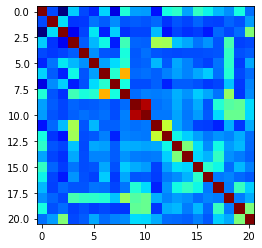

In [51]:
plt.imshow(corr_matrix,cmap='jet',interpolation='nearest')

We compute the corr matrix and observe the features most correlated with spam classification

In [52]:
corr_matrix["spam"].sort_values(ascending=False)

spam                           1.000000
subj_number_of_special_char    0.255245
subj_number_of_maj             0.245606
? or !                         0.225730
cont_mean_len_word             0.211090
number_mail_name               0.210738
subj_number_of_price           0.198541
price                          0.156737
html                           0.147508
subj_number_of_number          0.121901
subj_number_of_char            0.097610
Number count                   0.092265
Majuscule count                0.090614
cont_number_of_word            0.071601
cont_longuest_word             0.035571
hour                          -0.014715
url                           -0.015723
mail                          -0.059027
len_mail_name                 -0.085171
> count                       -0.151231
x-*                           -0.264207
Name: spam, dtype: float64

As it could be seen, 
#### the length of the __longuest word__ seems to be poorly related to the spam class, we might suppress this feature or try to find a more appropriate feature (try or suppress): 
-> __cont_longuest_word / cont_number_of_word__ ?  
-> __cont_longuest_word / cont_mean_len_word__ ?

 #### __hour__ seems to be not correlated to spam, we might try to see if there is a more appropriate feature (try or suppress):  
-> __send between 9am and 5pm (working hours)__  
  
 #### __Majuscule count__ & __Number count__ could be transform in (try):  
-> __Majuscule count / cont_number_of_word__  
-> __Number count / cont_number_of_word__    
 
 #### We might drop __cont_number_of_word__  
 -> drop __cont_number_of_word__  ?
 #### __subj_number_of_maj / subj_number_of_char__ might be even better than subj_number_of_maj only. 
 -> __subj_number_of_maj / subj_number_of_char__ ?
 -> __subj_number_of_number / subj_number_of_char__ ?  
 -> __subj_number_of_special_char / subj_number_of_char__  
 
 #### __url__ and __mail__ seems poorly correlated we might drop them or try to replace with:   
-> __url / html__ ?   
-> __mail / html__ ?  
-> __url / cont_number_of_word__ ?  
-> __mail / cont_number_of_word__ ?  

 #### html is already a good feature,  We could try 
 -> __html / cont_number_of_word__

 #### Split __ ? or ! __ in three cat : 0, 1 or >1  
 #### Similarly we could try to split __price__ in three cat : 0, 1, >1
-> Cat ? or !    

-> Cat price  

#### len mail name
-> number_mail_name / len_mail_name

-> drop len_mail_name

-> count_mean_len_word >10
 

In [53]:
domain = train_set[["domain", "spam"]].value_counts().groupby("spam")
domain.head()

domain              spam
0-5                 1.0     826
                    0.0     784
spamassassin.taint  0.0     546
example             0.0     537
5-10                0.0     503
10-15               0.0     349
yahoo               1.0     187
hotmail             1.0     186
5-10                1.0     149
25-30               1.0      84
dtype: int64

In [54]:
train_set_spam = train_set[train_set["spam"]==1.0]
train_set_ham = train_set[train_set["spam"]==0.0]

----
### 1. Hour
----

We study the approximative hour of spam sending

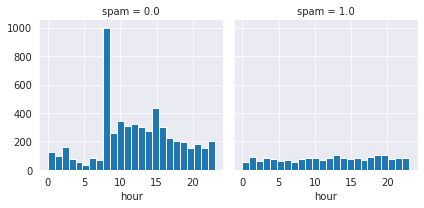

In [55]:
sns.set_style("darkgrid")
g = sns.FacetGrid(train_set, col='spam')
g.map(plt.hist, 'hour', bins=24)

It could be seen that the email sending know a peak at 9 am and 4 pm, so we could 
split within working hour or simply check if the mail was sent at (9am or 5pm) or not

#### CONCLUSION
try to add :  
 * hour between 9 and 17  
 * hour is 9 or 16

----
### 2. x-*
----

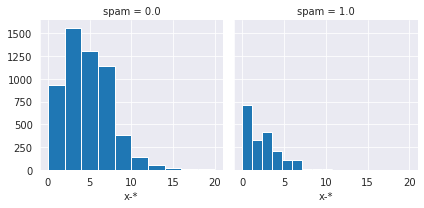

In [56]:
g = sns.FacetGrid(train_set, col='spam')
g.map(plt.hist, 'x-*')

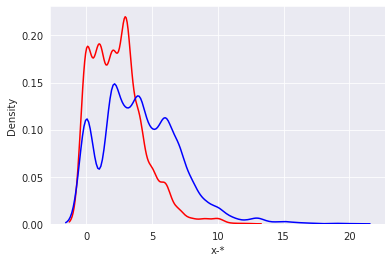

In [57]:
sns.kdeplot(train_set_spam["x-*"], color="r", label="spam")
sns.kdeplot(train_set_ham["x-*"], color="b", label="ham")
plt.show()

#### CONCLUSION
Leave this cat raw

---
### 3. Subj number of special char
---

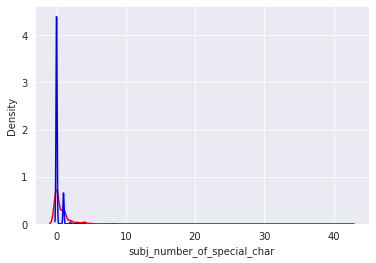

In [58]:
sns.kdeplot(train_set_spam["subj_number_of_special_char"], color="r", label="spam")
sns.kdeplot(train_set_ham["subj_number_of_special_char"], color="b", label="ham")
plt.show()

#### CONCLUSION
Leave this cat raw

----
### 4. Subj_number_of_maj
____

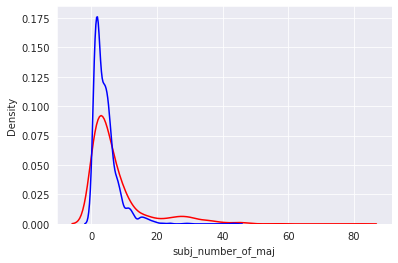

In [59]:
sns.kdeplot(train_set_spam["subj_number_of_maj"], color="r", label="spam")
sns.kdeplot(train_set_ham["subj_number_of_maj"], color="b", label="ham")
plt.show()

It seems subject of spam have a tendancy to be written with majuscule we could try to see 
if it the case by doing number_of_maj - subj_number_of_char or create a fake attributes

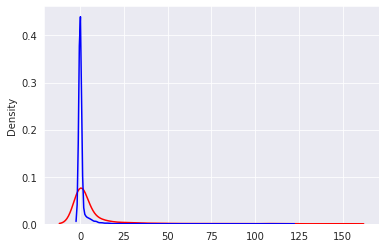

In [60]:
trainset_non_maj_spam = train_set_spam["subj_number_of_maj"] * train_set_spam["subj_number_of_special_char"]
trainset_non_maj_ham = train_set_ham["subj_number_of_maj"] * train_set_ham["subj_number_of_special_char"]

sns.kdeplot(trainset_non_maj_spam, color="r", label="spam")
sns.kdeplot(trainset_non_maj_ham, color="b", label="ham")
plt.show()

##### CONCLUSION :
try to add a feature :  
train_set["subj_number_of_maj"] * train_set["subj_number_of_special_char"]

---
### 5. > count
---

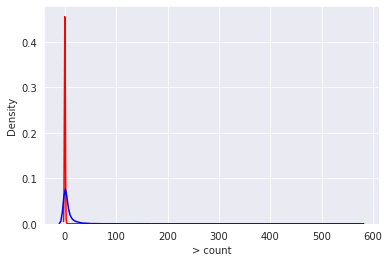

In [61]:
sns.kdeplot(train_set[train_set["spam"]==1.0]["> count"], color="r", label="spam")
sns.kdeplot(train_set[train_set["spam"]==0.0]["> count"], color="b", label="ham")
plt.show()

#### CONCLUSION
Leave this cat raw

---
### 6. Number count
---

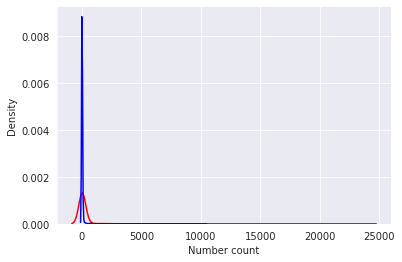

In [62]:
sns.kdeplot(train_set[train_set["spam"]==1.0]["Number count"], color="r", label="spam")
sns.kdeplot(train_set[train_set["spam"]==0.0]["Number count"], color="b", label="ham")
plt.show()

In [63]:
train_set[train_set["spam"]==1.0]["Number count"].describe()

count     1918.000000
mean       167.578728
std       1286.911248
min          0.000000
25%          3.000000
50%          8.000000
75%         25.000000
max      23869.000000
Name: Number count, dtype: float64

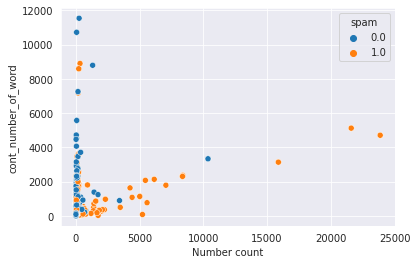

In [64]:
j = sns.scatterplot(x="Number count", y="cont_number_of_word", hue="spam", data=train_set,  color="r")
plt.show()

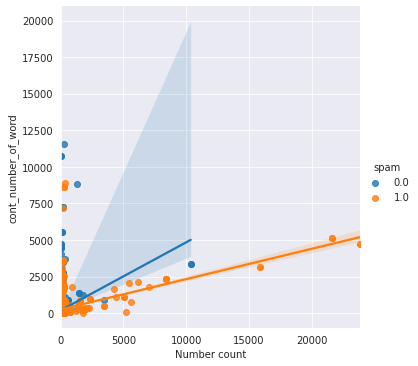

In [65]:
sns.lmplot(x="Number count", y="cont_number_of_word", hue="spam", data=train_set)

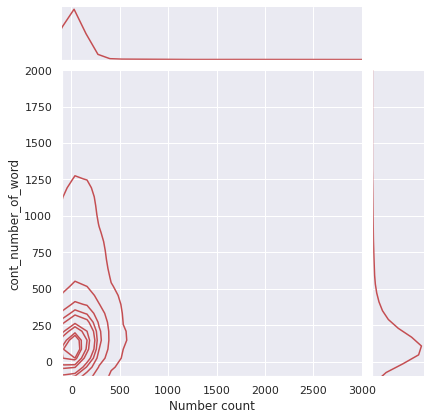

In [66]:
# 2D KDE plot
sns.set(style="darkgrid", color_codes=True)
j = sns.jointplot(x="Number count", y="cont_number_of_word",data=train_set, kind="kde", color="r")
j.ax_marg_x.set_xlim(-100, 3000)
j.ax_marg_y.set_ylim(-100, 2000)
plt.show()

#### CONCLUSION
try :
number / count_word

In [67]:
train_set.columns

Index(['spam', 'hour', 'content-type', 'x-*', 'html', 'url', 'mail', 'price',
       '> count', '? or !', 'Number count', 'Majuscule count', 'len_mail_name',
       'number_mail_name', 'domain', 'extension', 'subj_number_of_maj',
       'subj_number_of_char', 'subj_number_of_special_char',
       'subj_number_of_price', 'subj_number_of_number',
       'subj_common_word_list', 'cont_number_of_word', 'cont_mean_len_word',
       'cont_longuest_word', 'cont_count_common_word'],
      dtype='object')

----
### 7. Count longuest word
----

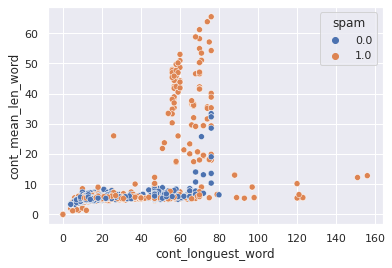

In [68]:
j = sns.scatterplot(x="cont_longuest_word", y="cont_mean_len_word", hue="spam", data=train_set,  color="r")
plt.show()

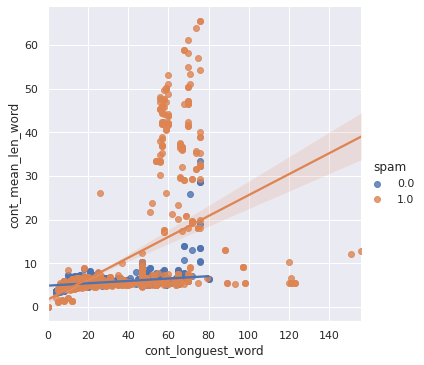

In [69]:
sns.lmplot(x="cont_longuest_word", y="cont_mean_len_word", hue="spam", data=train_set)

#### CONCLUSION
try to add a cat :  
cont_longuest_word / cont_mean_len_word

----
### 8. URL
----

Display the row with max url

In [70]:
train_set.iloc[train_set["url"].argmax()]

spam                                                                           0
hour                                                                           2
content-type                                                              unkown
x-*                                                                            0
html                                                                           0
url                                                                         3131
mail                                                                           6
price                                                                          0
> count                                                                        0
? or !                                                                       106
Number count                                                                 170
Majuscule count                                                             6057
len_mail_name               

In [71]:
train_set.iloc[train_set["html"].argmax()]

spam                                                                           1
hour                                                                           6
content-type                                               multipart/alternative
x-*                                                                            3
html                                                                        2299
url                                                                           88
mail                                                                           2
price                                                                          0
> count                                                                        0
? or !                                                                        79
Number count                                                                  21
Majuscule count                                                              745
len_mail_name               

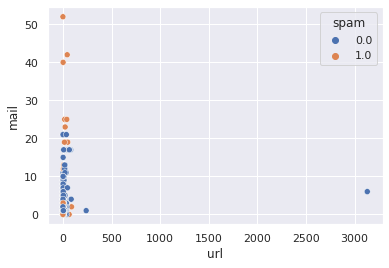

In [72]:
j = sns.scatterplot(x="url", y="mail", hue="spam", data=train_set,  color="r")
plt.show()

#### CONCLUSION
Drop the category

----
### 9. Subj_number_of_number
----

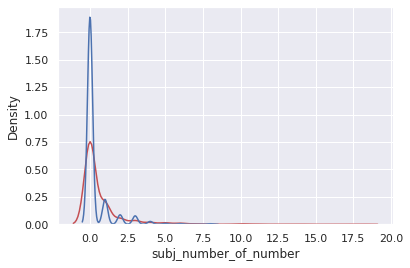

In [73]:
sns.kdeplot(train_set[train_set["spam"]==1.0]["subj_number_of_number"], color="r", label="spam")
sns.kdeplot(train_set[train_set["spam"]==0.0]["subj_number_of_number"], color="b", label="ham")
plt.show()

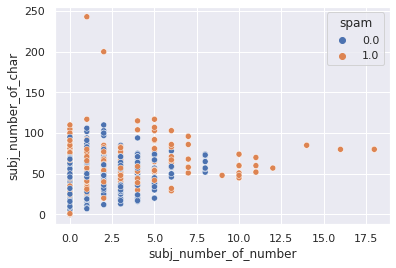

In [74]:
j = sns.scatterplot(x="subj_number_of_number", y="subj_number_of_char", hue="spam", data=train_set,  color="r")
plt.show()

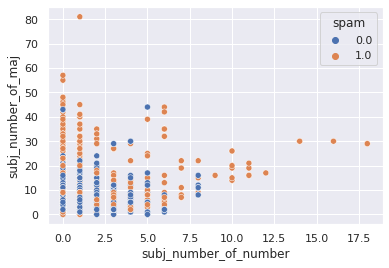

In [75]:
j = sns.scatterplot(x="subj_number_of_number", y="subj_number_of_maj", hue="spam", data=train_set,  color="r")
plt.show()

#### CONCLUSION 
Leave the cat raw

----
### 10. Subj number of special char
----

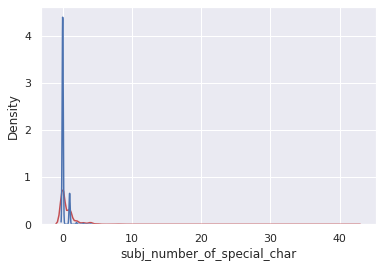

In [76]:
sns.kdeplot(train_set_spam["subj_number_of_special_char"], color="r", label="spam")
sns.kdeplot(train_set_ham["subj_number_of_special_char"], color="b", label="ham")
plt.show()

#### CONCLUSION
Leave the column raw

----
### 11. ? or !
----

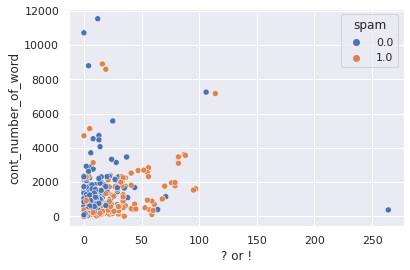

In [77]:
j = sns.scatterplot(x="? or !", y="cont_number_of_word", hue="spam", data=train_set,  color="r")
plt.show()

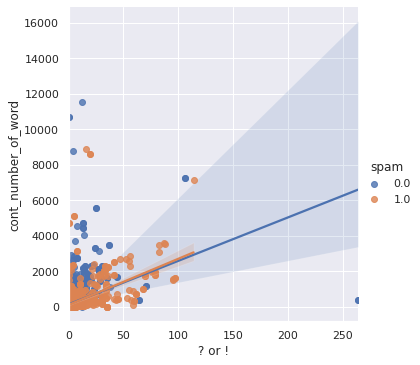

In [78]:
sns.lmplot(x="? or !", y="cont_number_of_word", hue="spam", data=train_set)

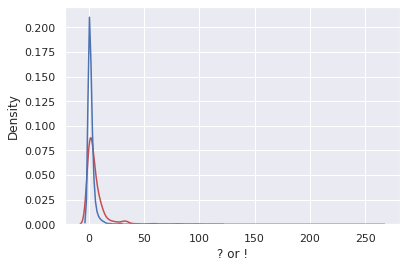

In [79]:
sns.kdeplot(train_set_spam["? or !"], color="r", label="spam")
sns.kdeplot(train_set_ham["? or !"], color="b", label="ham")
plt.show()

#### CONCLUSION 
add a feature :  
Leave cat raw

----
### 12. Price
----

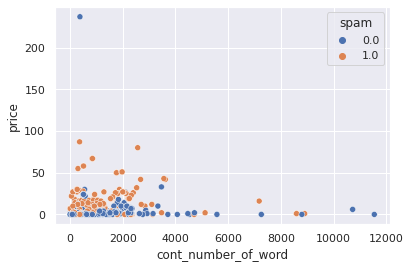

In [80]:
j = sns.scatterplot(x="cont_number_of_word", y="price", hue="spam", data=train_set,  color="r")
plt.show()

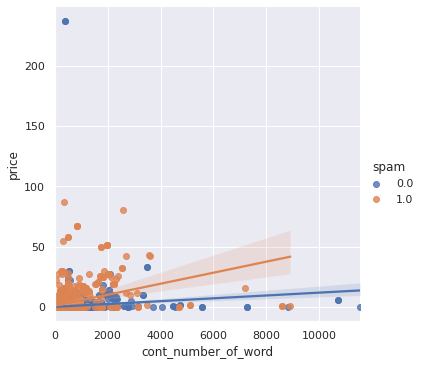

In [81]:
sns.lmplot(x="cont_number_of_word", y="price", hue="spam", data=train_set)

#### CONCLUSION
add a feature :  
price / cont_number_of_word

----
Create new features
----
----

In [82]:
train_set["working_hour"] = train_set["hour"].apply(lambda x: 1 if (9<x<17) else 0)

In [83]:
train_set["maj_over_count"] = train_set["Majuscule count"]/train_set["cont_number_of_word"]

In [84]:
train_set["num_over_count"] = train_set["Number count"]/train_set["cont_number_of_word"]

In [85]:
train_set["html_over_count"] = train_set["html"]/train_set["cont_number_of_word"]

In [86]:
train_set["subj_maj_time_spechar"] = train_set["subj_number_of_maj"]*train_set["subj_number_of_special_char"]

In [87]:
train_set["subj_num_over_len"] = train_set["subj_number_of_number"]/train_set["len_mail_name"]

In [88]:
new_corr = train_set.corr()

In [89]:
new_corr["spam"].sort_values(ascending=False)

spam                           1.000000
html_over_count                0.302049
subj_number_of_special_char    0.255245
maj_over_count                 0.248023
subj_maj_time_spechar          0.247449
subj_number_of_maj             0.245606
? or !                         0.225730
cont_mean_len_word             0.211090
number_mail_name               0.210738
subj_number_of_price           0.198541
price                          0.156737
html                           0.147508
subj_number_of_number          0.121901
num_over_count                 0.121557
subj_num_over_len              0.112630
subj_number_of_char            0.097610
Number count                   0.092265
Majuscule count                0.090614
cont_number_of_word            0.071601
cont_longuest_word             0.035571
hour                          -0.014715
url                           -0.015723
mail                          -0.059027
len_mail_name                 -0.085171
working_hour                  -0.094277


## CONCLUSION 
Drop (after the new features has been created):   
 * cont_number_of_word             
 * cont_longuest_word          
 * hour                         
 * url                                            
 * mail                            
 * html
 * price
 * Number count
 * Majuscule count 

---
Handle string value
----
---

In [90]:
ordinal_encoder = OrdinalEncoder()
train_set["extension_number"] = ordinal_encoder.fit_transform(train_set[["extension"]])

KeyboardInterrupt: 

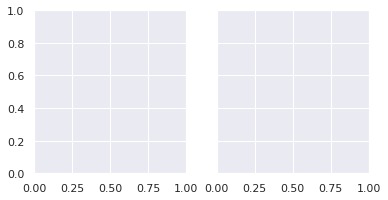

In [91]:
g = sns.FacetGrid(train_set, col='spam')
g.map(plt.hist, 'extension_number')

In [ ]:
train_set[train_set["spam"] == 1.0]["extension"].value_counts()

In [ ]:
ordinal_encoder = OrdinalEncoder()
train_set["domain_number"] = ordinal_encoder.fit_transform(train_set[["domain"]])

In [ ]:
g = sns.FacetGrid(train_set, col='spam')
g.map(plt.hist, 'domain_number')

In [ ]:
train_set[train_set["spam"] == 1.0]["domain"].value_counts()

In [ ]:
new_corr = train_set.corr()
new_corr["spam"].sort_values(ascending=False)

# Pipeline for extraction

In [6]:
class DataframeFunctionTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

In [7]:
def string2list(train_set, cat):
    new_train_set = train_set.copy(deep=True)
    new_train_set[cat] = new_train_set[cat].apply(lambda x:literal_eval(x))
    return new_train_set

In [8]:
string2list_pipeline = Pipeline([
    ('str2l', FunctionTransformer(
        func=string2list, 
        kw_args={'cat':"from"})),
    ('str2l1', FunctionTransformer(
        func=string2list, 
        kw_args={'cat':"subject"})),
    ('str2l2', FunctionTransformer(
        func=string2list, 
        kw_args={'cat':"content_attr"})),
]
)

In [9]:
new_train_set = string2list_pipeline.fit_transform(train_set)

In [10]:
def split_list(train_set, cat, names):
    new_train_set = train_set.copy(deep=True)
    if (len(names) == len(train_set[cat].iloc[0])):
        i=0
        for name in names:
            new_train_set[name] = new_train_set[cat].apply(lambda x:x[i])
            i+=1
    return new_train_set.drop(cat, axis=1)

In [11]:
split_list_pipeline = Pipeline([
    ('str2l', FunctionTransformer(
        func=string2list, 
        kw_args={'cat':"from"})),
    ('str2l1', FunctionTransformer(
        func=string2list, 
        kw_args={'cat':"subject"})),
    ('str2l2', FunctionTransformer(
        func=string2list, 
        kw_args={'cat':"content_attr"})),
    
    ('splitl', FunctionTransformer(
        func=split_list, 
        kw_args={
            'cat':"from",
            'names' : ("len_mail_name", 
                       "number_mail_name", 
                       "domain",
                       "extension"),
            })),
    ('splitl1', FunctionTransformer(
        func=split_list, 
        kw_args={
            'cat':"subject",
            'names' : ( "subj_number_of_maj",
                        "subj_number_of_char",
                        "subj_number_of_special_char",
                        "subj_number_of_price",
                        "subj_number_of_number",
                        "subj_common_word_list"),
        })),
    ('splitl2', FunctionTransformer(
        func=split_list, 
        kw_args={
            'cat':"content_attr",
            'names' : ( "cont_number_of_word",
                        "cont_mean_len_word",
                        "cont_longuest_word",
                        "cont_count_common_word"),
        })),
]
)


In [12]:
def divide_multiply(train_set, cat1, cat2, name, div=True):
    new_train_set = train_set.copy()
    if (div):
        new_train_set_cat = new_train_set[:, cat1]/new_train_set[:, cat2]
        new_train_set_cat[ ~ np.isfinite( new_train_set_cat )]  = 0
        #new_train_set = new_train_set.drop(cat1, axis=1)
        return np.c_[new_train_set[:, 0:cat1], new_train_set[:, cat1+1:], new_train_set_cat]
    else:
        new_train_set_cat = new_train_set[:, cat1]*new_train_set[:, cat2]
    return np.c_[new_train_set, new_train_set_cat]

In [13]:
def working_hour(train_set, index_hour):
    new_train_set = train_set.copy()
    new_train_set_working_hourless17 = new_train_set[:, index_hour] < 17
    new_train_set_working_hourup9 = new_train_set[:, index_hour] > 9
    new_train_set_working_hour = new_train_set_working_hourless17 & new_train_set_working_hourup9
    new_train_set_working_hour = new_train_set_working_hour.astype(int)
    return np.c_[new_train_set[:, :index_hour], new_train_set[:, index_hour+1:],new_train_set_working_hour]

In [14]:
index_hour = 0
index_html = 1
index_Number_count= 2
index_Majuscule_count = 3
index_subj_number_of_maj=4
index_cont_number_of_word=5
index_subj_number_of_special_char= 6

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    
    ('divide', FunctionTransformer(
        func=divide_multiply, 
        kw_args={
            'cat1': index_Majuscule_count,
            'cat2' : index_cont_number_of_word,
            'name': "maj_over_count",
        })),
    ('divide1', FunctionTransformer(
        func=divide_multiply, 
        kw_args={
            'cat1':index_Number_count,
            'cat2' : index_cont_number_of_word,
            'name': "num_over_count",
        })),
    ('divide2', FunctionTransformer(
        func=divide_multiply, 
        kw_args={
            'cat1': index_html,
            'cat2':  index_cont_number_of_word,
            'name': "html_over_count",
        })),
    ('multiply', FunctionTransformer(
        func=divide_multiply, 
        kw_args={
            'cat1': index_subj_number_of_maj,
            'cat2' : index_subj_number_of_special_char,
            'name': "subj_maj_time_spechar",
            'div' : False,
        })),
    
    ('working_hour', FunctionTransformer(
        func=working_hour,
        kw_args={
            'index_hour':index_hour,
        }
    )),
    ("scaler", StandardScaler()),
])

In [15]:
l_1020 = ['lycos', 'ximian', 'eecs.berkeley', 'maxtor', 'terra', 'waider', 'linuxworks.com',
 'caramail', 'ygingras', 'earthlink', 'cs.Helsinki', 'ckloiber', 'urgent.rug.ac', 'bennewitz',
 'mediaunspun.imakenews', 'wstoddard', 'lin12.triumf', 'mindspring', 'woozle', 'cs.helsinki',
 'freemail', 'punkass', 'noskillz', 'wanadoo', 'med.wayne', 'interlink.com', 'mad.scientist',
 'perkel', 'zanshin', 'FrugalJoe', 'email', 'netnoteinc', 'freeuk', 'kbs', 'paradigm-omega',
 'greenhydrant', 'deersoft', 'neo.pittstate', 'gmx', 'frogstone', 'ummail4.unitedmedia',
 'bluemail', 'baesystems', 'svanstrom', 'ie.suberic', 'list.theregister.co', 'Golux', 'alumni.rice',
 'ianbell', 'cunniffe', 'dmv', 'whump', 'lig', 'iol', 'bubbanfriends']

l_2030 = ['dogma.slashnull', 'netscape', 'talios', 'corvil', 'sendgreatoffers', 'srv0.ems.ed.ac',
 'eudoramail', 'kamakiriad', 'Flashmail', 'panix', 'excite', 'users.sourceforge', 'bellsouth',
 'redbrick.dcu', 'fastmail', 'pathname', 'kluge', 'vipul', 'linuxmafia', 'btamail.net']

l_sup30 = ['egwn','example', 'magnesium', 'aol', 'yahoo.co', 'endeavors', 'comcast', 'insurancemail',
 'acm', 'perl', 'iki', 'munnari.OZ', 'python', 'hotmail', 'spamassassin.taint', 'newsletter.online',
 'evergo', 'techmonkeys', 'alumni.caltech', 'barrera', 'panasas', 'yahoo', 'lockergnome',
 'rpmforge', 'eircom', 'petting-zoo', 'mithral', 'aminvestments', 'pobox', '2ubh', 'leitl',
 'slack', 'shipwright', 'DeepEddy', 'cse.ucsc', 'canada', 'msn', 'hughes-family', 'insiq',
 'silcom', 'permafrost', 'tuatha', 'argote', 'usa', 'best', 'mail', 'linux', '10-20', '20-30']

In [16]:
def bins_domain(train_set):
    new_train_set = train_set.copy(deep=True)
    
    new_train_set["domain"] = np.where(np.invert(new_train_set["domain"].isin(l_1020)), new_train_set["domain"], '10-20')
    new_train_set["domain"] = np.where(np.invert(new_train_set["domain"].isin(l_2030)), new_train_set["domain"], '20-30')
    new_train_set["domain"] = np.where(new_train_set["domain"].isin(l_sup30), new_train_set["domain"], '0-10')
    #print(new_train_set["domain"].value_counts())
    return new_train_set

In [17]:
l_34 = ['pt', 'th', 'no', 'ph', 'sk', 'bz', 'tr']
l_56 = ['kr', 'co', 'ro', 'cc', 'gr', 'hu', 'pl']
l_78 = ['to']
l_910 = ['tw', 'nl', 'se']
l_sup_9 = ['ie', 'it', 'ru', 'at', 'es', 'org', 'us',
 'dk', 'nu', 'za', 'fm', 'cn', 'fi', 'fr', 'com', 'be',
 'de', 'net', 'ch', 'br', 'jp', 'au', 'uk', 'ca', 'edu']

In [18]:
def bins_extension(train_set):
    new_train_set = train_set.copy(deep=True)
    new_train_set["extension"] = np.where(np.invert(new_train_set["extension"].isin(l_34)), new_train_set["extension"], '3-4')
    new_train_set["extension"] = np.where(np.invert(new_train_set["extension"].isin(l_56)), new_train_set["extension"], '5-6')
    new_train_set["extension"] = np.where(np.invert(new_train_set["extension"].isin(l_78)), new_train_set["extension"], '7-8')
    new_train_set["extension"] = np.where(np.invert(new_train_set["extension"].isin(l_910)), new_train_set["extension"], '9-10')
    new_train_set["extension"] = np.where(new_train_set["extension"].isin(l_sup_9), new_train_set["extension"], '1-2')
    new_train_set["extension"] = new_train_set["extension"].str.lower()
    return new_train_set

In [19]:
def bins_content_type(train_set):
    new_content_type = train_set.copy(deep=True)
    new_content_type["content-type"] = new_content_type["content-type"].str.lower()
    new_content_type["content-type"] = new_content_type["content-type"].str.replace(";", " ", regex=True)
    new_content_type["content-type"] = new_content_type["content-type"].str.replace('\"', " ", regex=True)
    new_content_type["content-type"] = new_content_type["content-type"].fillna("unkown")
    new_content_type["content-type"] = new_content_type["content-type"].str.split()
    new_content_type["content-type"] = new_content_type["content-type"].apply(lambda x: x[0])
    #new_content_type["content-type"] = new_content_type["content-type"].str.lower()
    return new_content_type

In [20]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0] 
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [21]:
domain_attribs = ["domain"]#, "extension", "content-type"
domains_cat =[l_sup30+["0-10"]]
bin_domain_pipeline = Pipeline([
    ('bins_domain', FunctionTransformer(func=bins_domain)),
    #('bins_extension', FunctionTransformer(func=bins_extension)),
    #('bins_content_type', FunctionTransformer(func=bins_content_type)), 
    ("one_hot",OneHotEncoder(handle_unknown="ignore", sparse=True, categories=domains_cat))
])

In [22]:
extension_attribs = ["extension"]#, "extension", "content-type"
extension_cat =[l_sup_9+["1-2"]]
bin_extension_pipeline = Pipeline([
    #('bins_domain', FunctionTransformer(func=bins_domain)),
    ('bins_extension', FunctionTransformer(func=bins_extension)),
    #('bins_content_type', FunctionTransformer(func=bins_content_type)), 
    ("one_hot",OneHotEncoder(handle_unknown="ignore", sparse=True, categories=extension_cat))
])

In [23]:
content_attribs = ["content-type"]#, "extension", "content-type"
content_cat = [['text/plain','unkown','text/html','multipart/alternative',
               'multipart/signed','multipart/mixed','multipart/related','multipart/report']]  
bin_content_pipeline = Pipeline([
    #('bins_domain', FunctionTransformer(func=bins_domain)),
    ('bins_content_type', FunctionTransformer(func=bins_content_type)),
    #('bins_content_type', FunctionTransformer(func=bins_content_type)), 
    ("one_hot",OneHotEncoder(handle_unknown="ignore", sparse=True, categories=content_cat))
])

In [24]:
def split_word_list(train_set, cat, name):
    new_train_set = train_set.copy(deep=True)
    if type(new_train_set[cat].iloc[0])==type([]):
        for i in range(len(new_train_set[cat].iloc[0])):
            new_train_set[name+str(i)] = new_train_set[cat].apply(lambda x:x[i])
        return new_train_set.drop(cat, axis=1)
    return new_train_set

In [25]:
word_list_attrib = ["subj_common_word_list", "cont_count_common_word"]

word_list_pipeline = Pipeline([
    ("content_list", FunctionTransformer(
        func=split_word_list,
        kw_args={
            'cat' : "cont_count_common_word",
            'name' : "cw"
        }
    )),
    ("subject_list", FunctionTransformer(
        func=split_word_list,
        kw_args={
            'cat' : "subj_common_word_list",
            'name' : "sw"
        }
    ))
])

In [26]:
num_attribs = [
    'hour','html','Number count','Majuscule count','subj_number_of_maj',
    "cont_number_of_word",'subj_number_of_special_char',
    'x-*', '> count', '? or !', 'number_mail_name','subj_number_of_char',
    'subj_number_of_price','subj_number_of_number',
    'cont_mean_len_word', "cont_longuest_word",
]
word_list_attrib = ["subj_common_word_list", "cont_count_common_word"]
cat_attribs = ["domain", "extension", "content-type"]

In [27]:
new_train_set = train_set.copy(deep=True)
#print(np.shape(new_train_set))
new_train_set = new_train_set[[
    'from', 'subject', 'content_attr', 'hour', 'content-type', 'x-*', 'html',
    'price', '> count', '? or !', 'Number count', 'Majuscule count',
    ]]

In [28]:
Full_pipeline = ColumnTransformer([
    ("Imputer", DataFrameImputer, []),
    ("num_pipeline", num_pipeline, num_attribs),
    ("domain_pipeline", bin_domain_pipeline, domain_attribs),
    ("extension_pipeline", bin_extension_pipeline, extension_attribs),
    ("content_pipeline", bin_content_pipeline, content_attribs),
])

In [29]:
#print(np.shape(new_train_set))
new_train_set = split_list_pipeline.fit_transform(new_train_set)
#print(np.shape(new_train_set))
new_train_set = word_list_pipeline.fit_transform(new_train_set)
#print(np.shape(new_train_set))
X_train_set_prepared = Full_pipeline.fit_transform(new_train_set)
#print(np.shape(X_train_set_prepared))
y_train_set_prepared = train_set["spam"]

<ipython-input-12-9e34b35a0039>:4: RuntimeWarning: invalid value encountered in true_divide
  new_train_set_cat = new_train_set[:, cat1]/new_train_set[:, cat2]
<ipython-input-12-9e34b35a0039>:4: RuntimeWarning: divide by zero encountered in true_divide
  new_train_set_cat = new_train_set[:, cat1]/new_train_set[:, cat2]


In [30]:
np.shape(X_train_set_prepared)

(7479, 101)

In [29]:
#np.count_nonzero(~np.isnan(X_train_set_prepared))

# Logistic Regression

In [28]:
log_reg1 = LogisticRegression(penalty='l2', # Type of regression for regularized linear model 
                             dual=False, #
                             tol=0.0001, # tolerance for stopping
                             C=1.0,      #
                             fit_intercept=True, 
                             intercept_scaling=1, 
                             class_weight=None, # Give weight to class
                             random_state=None, 
                             solver='lbfgs', 
    #1 For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ 
    #  are faster for large ones.
    #2 For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle 
    #  multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #3 ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
    #4 ‘liblinear’ and ‘saga’ also handle L1 penalty
    #5 ‘saga’ also supports ‘elasticnet’ penalty
    #6 ‘liblinear’ does not support setting penalty='none'
                             max_iter=100, # max number of iteration to converge
                             multi_class='auto', # auto select ovr when binary multinomial in multclassification
                             verbose=0, # set verbosity 0=False, 1=True
                             warm_start=False, #if True reuse last solution for initialization
                             n_jobs=None, # number of CPU cores when parallelizing
                             l1_ratio=None # Elastic Net parameter
                            )

In [32]:
log_reg1.fit(X_train_set_prepared, y_train_set_prepared)

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
np.shape(X_train_set_prepared)

(7479, 109)

In [63]:
def select_some_mail(i,X_train_set_prepared, y_train_set_prepared):
    i = i % np.shape(X_train_set_prepared)[0]
    X_some_mail = X_train_set_prepared[i]
    y_some_mail = y_train_set_prepared.iloc[i]
    print(y_some_mail)
    return X_some_mail, y_some_mail

In [64]:
X_some_mail, y_some_mail = select_some_mail(5000, X_train_set_prepared, y_train_set_prepared)

1.0


In [36]:
log_reg1.predict(X_some_mail)

array([1.])

In [71]:
def plot_precision_recall_vs_threshold(y_train, y_predict):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_predict)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid()
    #plt.axis([-5, 1, 0, 5])
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

In [72]:
def plot_roc_curve(y_train, y_predict, trace_type="b-", label=None):
    fpr, tpr, thresholds = roc_curve(y_train, y_predict)
    plt.plot(fpr, tpr, trace_type, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
    plt.grid("on")
    plt.ylabel('tpr')
    plt.xlabel('fpr')

In [73]:
def display_score(model, X_train, y_train, cv=5):
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=cv)
    y_predict = cross_val_predict(model, X_train, y_train, cv=cv)
    
    print("Scores : ", score)
    print("Mean : ", score.mean())
    print("Standard deviation :", score.std())
    print("Confusion Matrix : \n", confusion_matrix(y_train, y_predict))
    print("Precision : ", precision_score(y_train, y_predict))
    print("Recall : ",recall_score(y_train, y_predict))
    print("F1_score", f1_score(y_train, y_predict))
    print("ROC Area Under Curve :", roc_auc_score(y_train, y_predict))
    
    plot_precision_recall_vs_threshold(y_train, y_predict)
    plot_roc_curve(y_train, y_predict)

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Scores :  [0.94251337 0.93649733 0.94652406 0.9565508  0.94849498]
Mean :  0.9461161089549837
Standard deviation : 0.006636399766004998
Confusion Matrix : 
 [[5406  155]
 [ 248 1670]]
Precision :  0.915068493150685
Recall :  0.8706986444212722
F1_score 0.892332353726957
ROC Area Under Curve : 0.921412979826173


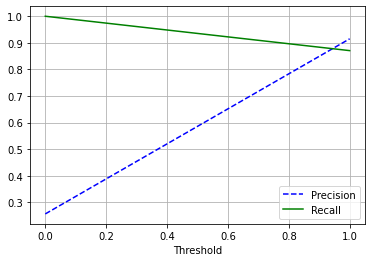

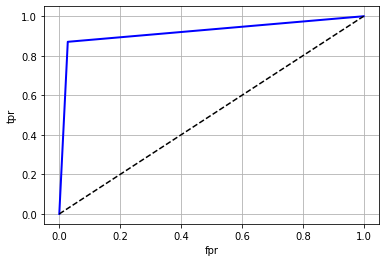

In [40]:
display_score(log_reg1, X_train_set_prepared, y_train_set_prepared)

In [41]:
log1bis = LogisticRegression(penalty='none', solver='lbfgs')

log2 = LogisticRegression(penalty='l2', solver='newton-cg')
log2bis = LogisticRegression(penalty='none', solver='newton-cg')

log3 = LogisticRegression(penalty='l2', solver='liblinear')
log3bis = LogisticRegression(penalty='l1', solver='liblinear')

log4 = LogisticRegression(penalty='l2', solver='saga')
log4bis = LogisticRegression(penalty='l1', solver='saga')
log4ter = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio = 0.5)
log4quar = LogisticRegression(penalty='none', solver='saga')


#### No penalty lbfgs

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
   

Scores :  [0.94251337 0.94385027 0.94719251 0.95454545 0.95117057]
Mean :  0.9478544345679895
Standard deviation : 0.004489208596685929
Confusion Matrix : 
 [[5405  156]
 [ 234 1684]]
Precision :  0.9152173913043479
Recall :  0.8779979144942649
F1_score 0.8962213943587015
ROC Area Under Curve : 0.9249727029763178


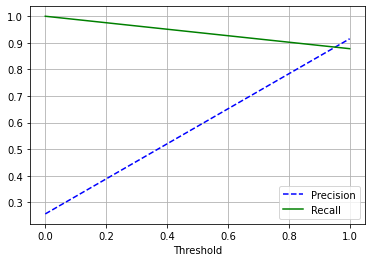

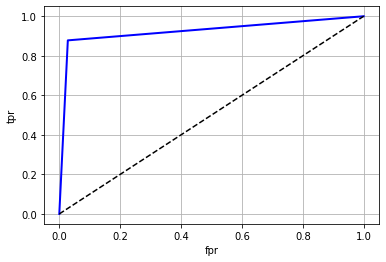

In [42]:
display_score(log1bis, X_train_set_prepared, y_train_set_prepared)

 ### Ridge Regression Newton-cg -> l2
 A regularization term $\alpha\sum_{i=1}^{n}{\theta_i^2} $

Scores :  [0.94251337 0.93649733 0.94652406 0.9565508  0.94849498]
Mean :  0.9461161089549837
Standard deviation : 0.006636399766004998
Confusion Matrix : 
 [[5406  155]
 [ 248 1670]]
Precision :  0.915068493150685
Recall :  0.8706986444212722
F1_score 0.892332353726957
ROC Area Under Curve : 0.921412979826173


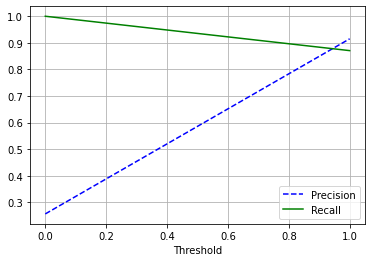

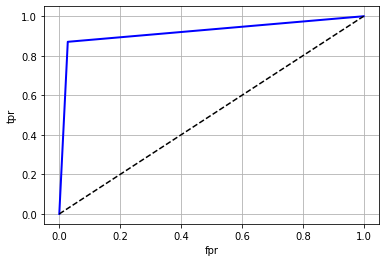

In [43]:
display_score(log2, X_train_set_prepared, y_train_set_prepared)

### No penalty Newton

Scores :  [0.94251337 0.94184492 0.94786096 0.95454545 0.95117057]
Mean :  0.9475870548888452
Standard deviation : 0.004900006645742948
Confusion Matrix : 
 [[5404  157]
 [ 235 1683]]
Precision :  0.9146739130434782
Recall :  0.8774765380604796
F1_score 0.8956891963810537
ROC Area Under Curve : 0.9246221028730739


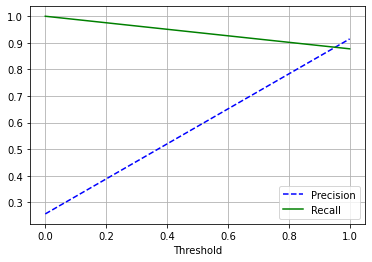

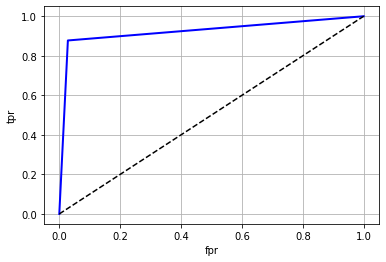

In [44]:
display_score(log2bis, X_train_set_prepared, y_train_set_prepared)

#### Ridge Regression with liblinear

Scores :  [0.94318182 0.93516043 0.94518717 0.95721925 0.94782609]
Mean :  0.9457149500116253
Standard deviation : 0.007140015409053853
Confusion Matrix : 
 [[5406  155]
 [ 251 1667]]
Precision :  0.9149286498353457
Recall :  0.8691345151199166
F1_score 0.8914438502673797
ROC Area Under Curve : 0.9206309151754951


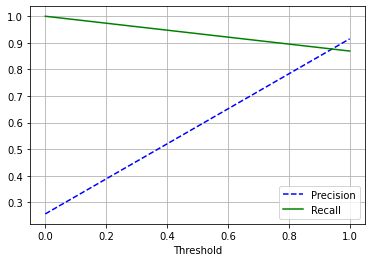

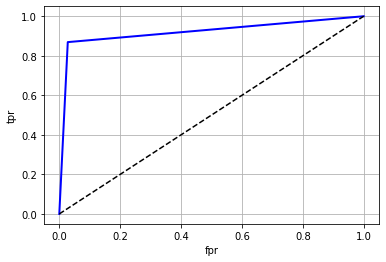

In [45]:
display_score(log3, X_train_set_prepared, y_train_set_prepared)

### Lasso Regression with liblinear
Regularization $\alpha\sum_{i=1}^{n}{|\theta_i|} $

Scores :  [0.94184492 0.94184492 0.94852941 0.95320856 0.95050167]
Mean :  0.9471858959454866
Standard deviation : 0.004607035832359738
Confusion Matrix : 
 [[5407  154]
 [ 241 1677]]
Precision :  0.9158929546695794
Recall :  0.8743482794577685
F1_score 0.8946385702854094
ROC Area Under Curve : 0.9233277092307723


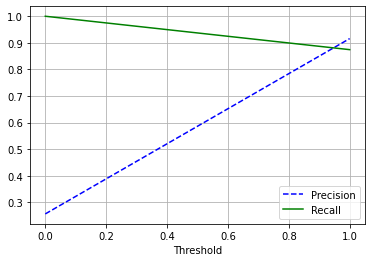

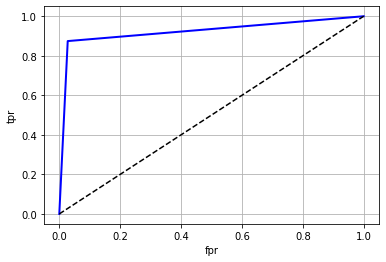

In [46]:
display_score(log3bis, X_train_set_prepared, y_train_set_prepared)

### Saga with Ridge regression
log4 = LogisticRegression(penalty='l2', solver='saga')  
log4bis = LogisticRegression(penalty='l1', solver='saga')  
log4ter = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio = 0.5)  
log4quar = LogisticRegression(penalty='none', solver='saga')

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Scores :  [0.93181818 0.92245989 0.93114973 0.93783422 0.93377926]
Mean :  0.9314082592599217
Standard deviation : 0.005044260608218942
Confusion Matrix : 
 [[5389  172]
 [ 340 1578]]
Precision :  0.9017142857142857
Recall :  0.8227320125130344
F1_score 0.8604143947655397
ROC Area Under Curve : 0.8959011618040805


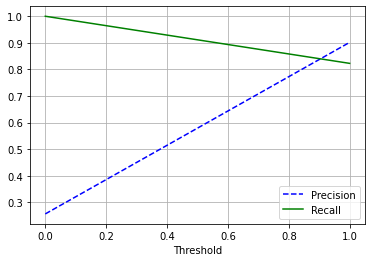

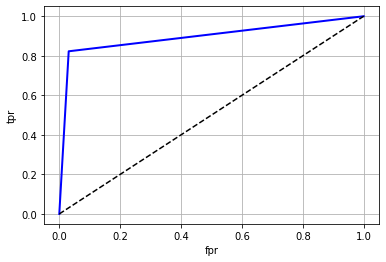

In [47]:
display_score(log4, X_train_set_prepared, y_train_set_prepared)

### Saga solver with lasso regression

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Scores :  [0.93114973 0.92245989 0.93181818 0.93649733 0.93244147]
Mean :  0.9308733210523492
Standard deviation : 0.004600944815856976
Confusion Matrix : 
 [[5389  172]
 [ 344 1574]]
Precision :  0.9014891179839634
Recall :  0.8206465067778936
F1_score 0.8591703056768558
ROC Area Under Curve : 0.8948584089365101


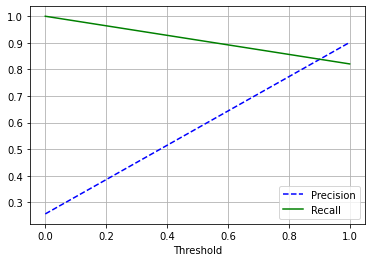

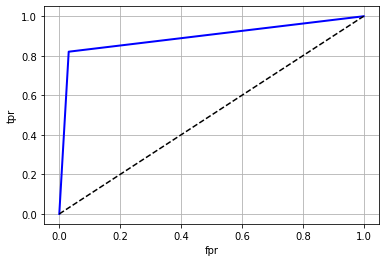

In [48]:
display_score(log4bis, X_train_set_prepared, y_train_set_prepared)

#### Saga with elastic Net
$r\alpha\sum_{i=1}^{n}{|\theta_i|}+\frac{1-r}{2}\alpha\sum_{i=1}^{n}{\theta_i^2} $

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Scores :  [0.93114973 0.92245989 0.93181818 0.93649733 0.93311037]
Mean :  0.9310071003165632
Standard deviation : 0.0046540146980926355
Confusion Matrix : 
 [[5389  172]
 [ 344 1574]]
Precision :  0.9014891179839634
Recall :  0.8206465067778936
F1_score 0.8591703056768558
ROC Area Under Curve : 0.8948584089365101


/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


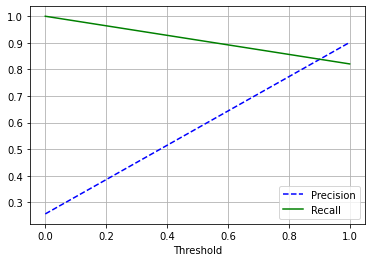

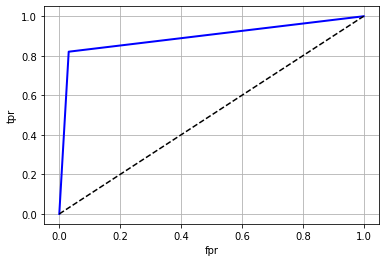

In [49]:
display_score(log4ter, X_train_set_prepared, y_train_set_prepared)

#### Saga with no penalty

/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Scores :  [0.93181818 0.92245989 0.93114973 0.93649733 0.93377926]
Mean :  0.9311408795807772
Standard deviation : 0.004721672114180789
Confusion Matrix : 
 [[5386  175]
 [ 340 1578]]
Precision :  0.9001711351968055
Recall :  0.8227320125130344
F1_score 0.8597112503405065
ROC Area Under Curve : 0.8956314261450264


/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


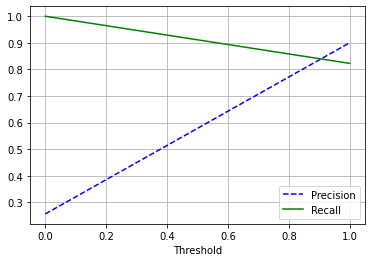

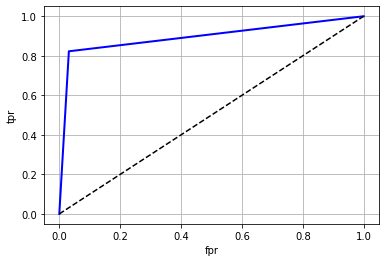

In [50]:
display_score(log4quar, X_train_set_prepared, y_train_set_prepared)

## Conclusion

Among Logistic Regression seems to be the good method here as it fast coupled with lasso regression l1, because it tends to supress least important features with sparse dataset (the dataset is sparsed because of the word vector) 

**logreg1 = LogisticRegression(penalty="l2", solver="lbfgs")**

Results are good, as follow :  

  
*Scores* :  [0.94184492 0.94184492 0.94852941 0.95320856 0.95050167]  
*Mean* :  0.9471858959454866  
*Standard deviation* : 0.004607035832359738  
*Confusion Matrix* :   
 [[5408  153]  
 [ 241 1677]]  
*Precision* :  0.9163934426229509  
*Recall* :  0.8743482794577685  
*F1_score* 0.8948772678762007    
*ROC Area Under Curve* : 0.9234176211171238  


# Stochastic Gradient Descent

Scores :  [0.94585561 0.94518717 0.94585561 0.95053476 0.91973244]
Mean :  0.9414331193103571
Standard deviation : 0.011017886102727588
Confusion Matrix : 
 [[5384  177]
 [ 259 1659]]
Precision :  0.9035947712418301
Recall :  0.864963503649635
F1_score 0.8838572189664358
ROC Area Under Curve : 0.916567347940624


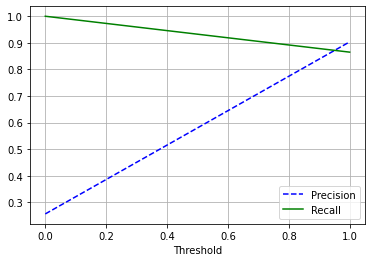

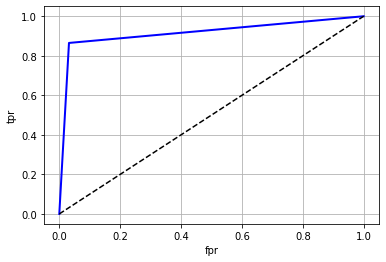

In [70]:
sgd_clf = SGDClassifier(penalty="elasticnet")
sgd_clf.fit(X_train_set_prepared,y_train_set_prepared)
display_score(sgd_clf, X_train_set_prepared, y_train_set_prepared)

# Support Vector Machine


/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/hugo/Machine_learning/Machine_learning_course/ml_env/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Scores :  [0.94318182 0.93783422 0.94451872 0.95320856 0.95183946]
Mean :  0.9461165560781929
Standard deviation : 0.005706328811501358
Confusion Matrix : 
 [[5399  162]
 [ 237 1681]]
Precision :  0.9120998372219208
Recall :  0.8764337851929093
F1_score 0.8939111938314278
ROC Area Under Curve : 0.9236511670075319


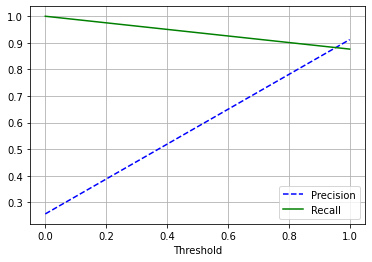

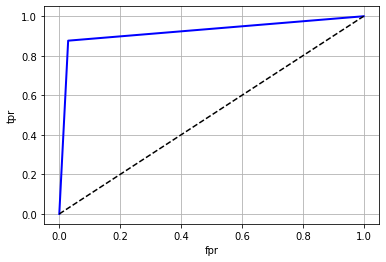

In [53]:
svm_clf = LinearSVC(C=1, loss="hinge")
svm_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(svm_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.96256684 0.96256684 0.96657754 0.96256684 0.96454849]
Mean :  0.9637653139699175
Standard deviation : 0.0016019346140136743
Confusion Matrix : 
 [[5442  119]
 [ 152 1766]]
Precision :  0.9368700265251989
Recall :  0.9207507820646507
F1_score 0.9287404680515383
ROC Area Under Curve : 0.9496758765565118


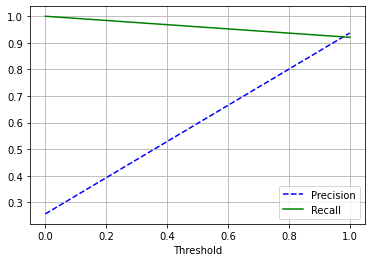

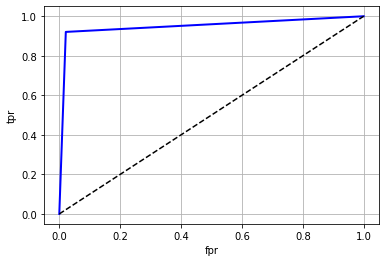

In [58]:
svc2_clf = SVC(kernel="poly", degree=2, coef0=1, C=5)
svc2_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(svc2_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.97393048 0.96524064 0.96925134 0.96791444 0.96588629]
Mean :  0.9684446372042279
Standard deviation : 0.0030931246340062486
Confusion Matrix : 
 [[5467   94]
 [ 142 1776]]
Precision :  0.9497326203208556
Recall :  0.9259645464025026
F1_score 0.9376979936642028
ROC Area Under Curve : 0.954530555884222


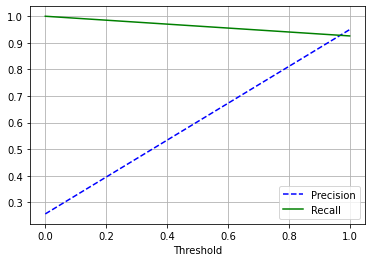

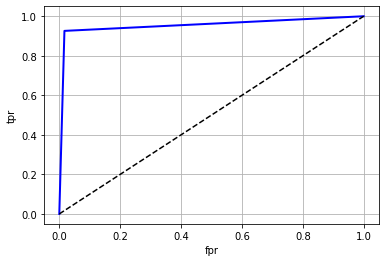

In [56]:
svc3_clf = SVC(kernel="poly", degree=3, coef0=1, C=5)
svc3_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(svc3_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.96925134 0.96858289 0.97393048 0.9618984  0.96521739]
Mean :  0.9677760985817253
Standard deviation : 0.0040447011521633595
Confusion Matrix : 
 [[5463   98]
 [ 143 1775]]
Precision :  0.9476775226908702
Recall :  0.9254431699687174
F1_score 0.9364283830123978
ROC Area Under Curve : 0.9539102201219238


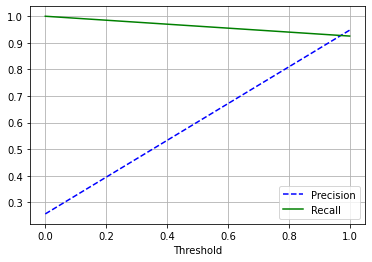

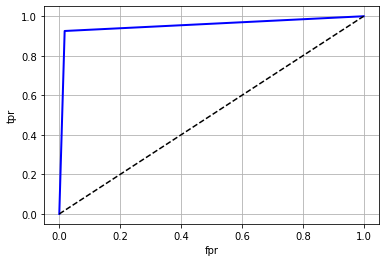

In [59]:
svc4_clf = SVC(kernel="poly", degree=4, coef0=1, C=5)
svc4_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(svc4_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.89171123 0.88302139 0.89237968 0.89505348 0.8909699 ]
Mean :  0.8906271350133241
Standard deviation : 0.004044848719992534
Confusion Matrix : 
 [[5536   25]
 [ 793 1125]]
Precision :  0.9782608695652174
Recall :  0.586548488008342
F1_score 0.7333767926988266
ROC Area Under Curve : 0.7910264468453867


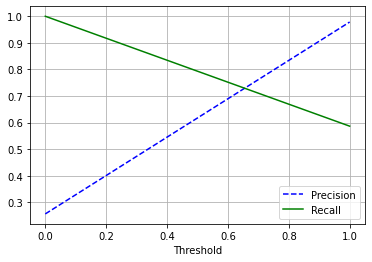

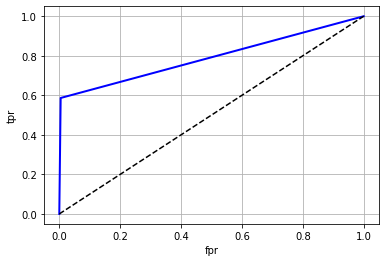

In [62]:
rbf_clf = SVC(kernel="rbf", gamma=1, C=1000)
rbf_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(rbf_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.64237968 0.6697861  0.65909091 0.6644385  0.66086957]
Mean :  0.6593129504766333
Standard deviation : 0.009221345863763204
Confusion Matrix : 
 [[4290 1271]
 [1277  641]]
Precision :  0.3352510460251046
Recall :  0.33420229405630864
F1_score 0.33472584856396864
ROC Area Under Curve : 0.5528231394755558


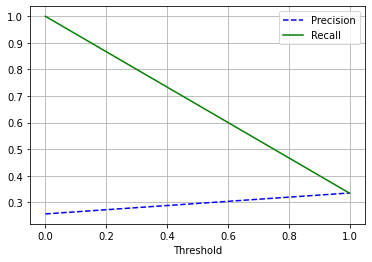

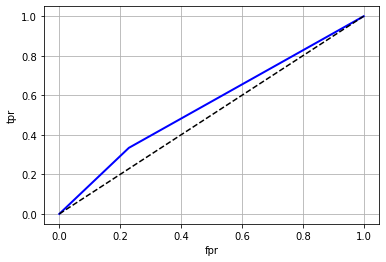

In [65]:
sigm_clf = SVC(kernel="sigmoid", gamma=1 ,C=10)
sigm_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(sigm_clf, X_train_set_prepared, y_train_set_prepared)

### Conclusion 
SVM with Polynomial Features kernel degree=3 is the best model for SVM kernel (check if it's not overfitting)

# Decision Tree Classifier

Scores :  [0.95053476 0.94050802 0.93850267 0.94986631 0.94180602]
Mean :  0.9442435569545544
Standard deviation : 0.004980926274499145
Confusion Matrix : 
 [[5413  148]
 [ 270 1648]]
Precision :  0.9175946547884187
Recall :  0.8592283628779979
F1_score 0.8874528809908455
ROC Area Under Curve : 0.9163072222589953


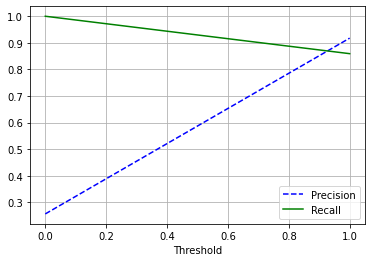

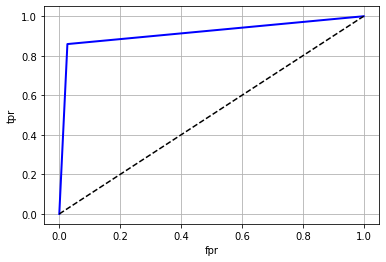

In [86]:
tree_clf = DecisionTreeClassifier(max_depth=10)
tree_clf.fit(X_train_set_prepared, y_train_set_prepared)
display_score(tree_clf, X_train_set_prepared, y_train_set_prepared)

In [87]:
export_graphviz(
tree_clf,
out_file="tree_spam.dot",
rounded=True,
filled=True
)

In [29]:
rnd_clf = RandomForestClassifier()
display_score(rnd_clf, X_train_set_prepared, y_train=y_train_set_prepared)

In [33]:
log_reg = LogisticRegression(penalty="l2", solver="lbfgs")
tree_clf = DecisionTreeClassifier(max_depth=10)
svc3_clf = SVC(kernel="poly", degree=3, coef0=1, C=5, probability=True)
rnd_clf = RandomForestClassifier()
extra_tree_clf = ExtraTreesClassifier()

voting_clf = VotingClassifier([#("lr", log_reg),
                              #("tc", tree_clf),
                              ("svc", svc3_clf),
                              ("rf", rnd_clf),
                              ("ex_tr", extra_tree_clf)
                             ],
                             voting="soft"
                             )

Scores :  [0.98529412 0.97860963 0.97860963 0.98262032 0.97859532]
Mean :  0.9807458015130649
Standard deviation : 0.0027550708672582996
Confusion Matrix : 
 [[5511   50]
 [  94 1824]]
Precision :  0.9733191035218783
Recall :  0.9509906152241918
F1_score 0.9620253164556962
ROC Area Under Curve : 0.9709997132945271


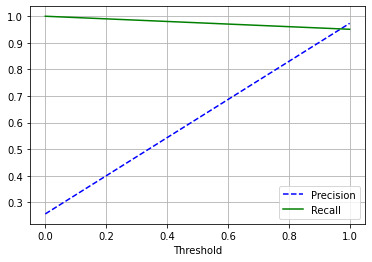

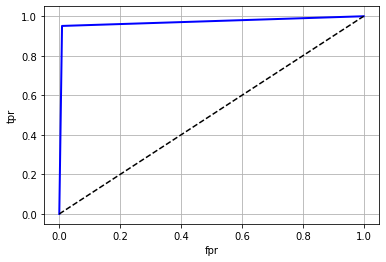

In [76]:
display_score(voting_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.89171123 0.87566845 0.88569519 0.88770053 0.88829431]
Mean :  0.885813943090158
Standard deviation : 0.005430186210850503
Confusion Matrix : 
 [[5420  141]
 [ 712 1206]]
Precision :  0.8953229398663697
Recall :  0.6287799791449427
F1_score 0.7387442572741193
ROC Area Under Curve : 0.8017124135969274


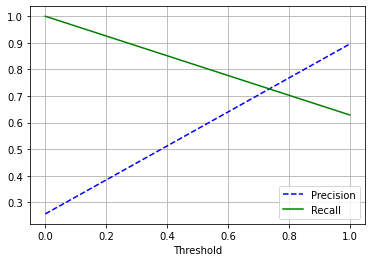

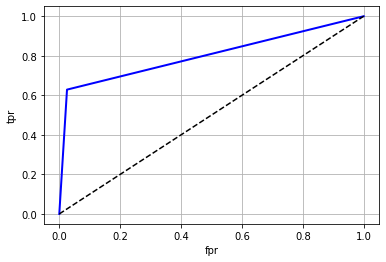

In [50]:
# bagging bootstrap=True
bag_clf = BaggingClassifier(rnd_clf, n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
display_score(bag_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.98328877 0.97994652 0.97326203 0.98262032 0.97658863]
Mean :  0.9791412551642731
Standard deviation : 0.003769228074766641
Confusion Matrix : 
 [[5506   55]
 [ 107 1811]]
Precision :  0.9705251875669882
Recall :  0.9442127215849844
F1_score 0.9571881606765329
ROC Area Under Curve : 0.9671612070431667


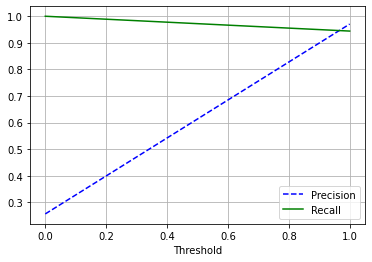

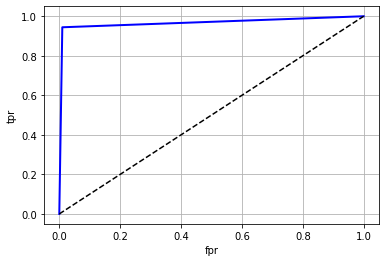

In [77]:
extra_tree_clf = ExtraTreesClassifier()
display_score(extra_tree_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.94719251 0.95120321 0.9552139  0.95454545 0.95317726]
Mean :  0.9522664675477974
Standard deviation : 0.002883963624489196
Confusion Matrix : 
 [[5403  158]
 [ 199 1719]]
Precision :  0.9158231220031966
Recall :  0.8962460896767466
F1_score 0.9059288537549407
ROC Area Under Curve : 0.9339169667948559


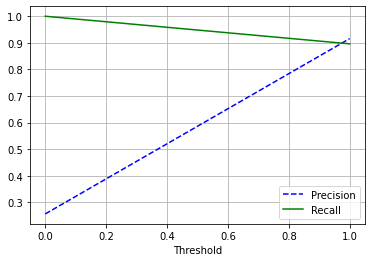

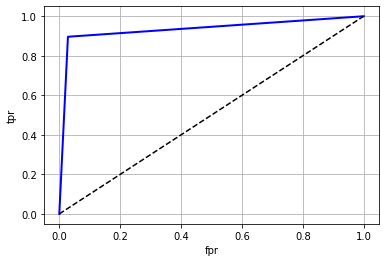

In [56]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, max_leaf_nodes=4), 
                             n_estimators=200, 
                             algorithm="SAMME.R",
                             learning_rate=0.5)
display_score(ada_clf, X_train_set_prepared, y_train_set_prepared)

Scores :  [0.92379679 0.90641711 0.92446524 0.92847594 0.92575251]
Mean :  0.9217815177150215
Standard deviation : 0.00784745374396191
Confusion Matrix : 
 [[5415  146]
 [ 439 1479]]
Precision :  0.9101538461538462
Recall :  0.7711157455683003
F1_score 0.8348856900931414
ROC Area Under Curve : 0.8724307373768494


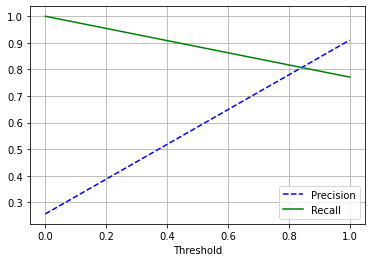

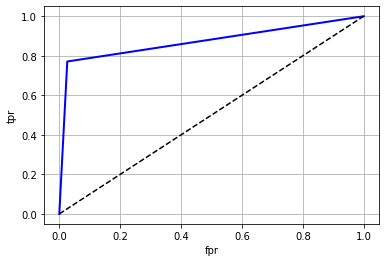

In [57]:
ada_clf2 = AdaBoostClassifier(LogisticRegression(penalty="l2", solver="lbfgs"), 
                             n_estimators=200, 
                             algorithm="SAMME.R",
                             learning_rate=0.5)
display_score(ada_clf2, X_train_set_prepared, y_train_set_prepared)

In [35]:
grad_clf = GradientBoostingClassifier(max_depth=5, 
                                      max_leaf_nodes=5, 
                                      n_estimators=200, 
                                      learning_rate=1.0)
#display_score(grad_clf, X_train_set_prepared, y_train_set_prepared)

In [31]:
new_test_set = strat_test_set.copy(deep=True)
#print(np.shape(new_test_set))
y_test_prepared = new_test_set["spam"] 

new_test_set = new_test_set[[
    'from', 'subject', 'content_attr', 'hour', 'content-type', 'x-*', 'html',
    'price', '> count', '? or !', 'Number count', 'Majuscule count',
    ]]
#print(np.shape(new_test_set))
new_test_set = split_list_pipeline.fit_transform(new_test_set)
#print(np.shape(new_test_set))
new_test_set = word_list_pipeline.fit_transform(new_test_set)
X_test_set_prepared = Full_pipeline.fit_transform(new_test_set)
print(np.shape(X_test_set_prepared))

(1870, 101)


<ipython-input-12-9e34b35a0039>:4: RuntimeWarning: invalid value encountered in true_divide
  new_train_set_cat = new_train_set[:, cat1]/new_train_set[:, cat2]
<ipython-input-12-9e34b35a0039>:4: RuntimeWarning: divide by zero encountered in true_divide
  new_train_set_cat = new_train_set[:, cat1]/new_train_set[:, cat2]


In [34]:
y_test_voting_pred = voting_clf.fit(X_train_set_prepared, y_train_set_prepared)
y_test_rnd_pred = rnd_clf.fit(X_train_set_prepared, y_train_set_prepared)
y_test_exttree_pred = extra_tree_clf.fit(X_train_set_prepared, y_train_set_prepared)
y_test_grad_pred = grad_clf.fit(X_train_set_prepared, y_train_set_prepared)

NameError: name 'grad_clf' is not defined

In [36]:
y_test_grad_pred = grad_clf.fit(X_train_set_prepared, y_train_set_prepared)

In [37]:
y_test_voting_pred = voting_clf.predict(X_test_set_prepared)
y_test_rnd_pred = rnd_clf.predict(X_test_set_prepared)
y_test_exttree_pred = extra_tree_clf.predict(X_test_set_prepared)
y_test_grad_pred = grad_clf.predict(X_test_set_prepared)

In [215]:
confusion_matrix(y_test_exttree_pred, y_test_prepared)

array([[1381,   53],
       [   9,  427]])

In [38]:
errory_extr_tree = mean_squared_error(y_test_prepared, y_test_exttree_pred)
1-errory_extr_tree

0.9727272727272728

In [39]:
errory_rnd = mean_squared_error(y_test_prepared, y_test_rnd_pred)
1-errory_rnd

0.9080213903743315

In [40]:
errory_voting = mean_squared_error(y_test_prepared, y_test_voting_pred)
1-errory_voting

0.9625668449197861

In [42]:
errory_grad = mean_squared_error(y_test_prepared, y_test_grad_pred)
1-errory_grad

0.8818181818181818

In [43]:
import joblib
filename = "extra_tree_model.sav"
joblib.dump(extra_tree_clf, filename)

['extra_tree_model.sav']